In [1]:
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt  
import seaborn as sns
from numpy import set_printoptions
from statistics import mean
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

In [2]:
# Split dataframe into train and test data
# Note: Stratify preserves the propotion of Revenue of T/F in the testing and training sets
def svm_training (df, resampling):
    
    f1_scores_macro = []
    recalls_macro = []
    precisions_macro = []
    f1_scores_weighted = []
    recalls_weighted = []
    precisions_weighted = []
    accuracies = []
    auroc = []
    aucpr = []

    y_preds = []
    y_pred_probs = []
    y_trues = []
    
    # Split dataframe into X and y
    X = df.drop(columns=["Revenue"])
    y = df["Revenue"].values

    for i in range(10):
        print("__________________________________________________________________________________Iteration:"+str(i))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
        y_trues.append(y_test)
        
        if (resampling=="under"):
            # Put the training data back together
            df_train = X_train.copy()
            df_train['Revenue'] = y_train
            # Get the counts of majority and minority classes
            count_class_0, count_class_1 = df_train['Revenue'].value_counts()
            # Slit into both classes
            df_class_0 = df_train[df_train['Revenue'] == 0]
            df_class_1 = df_train[df_train['Revenue'] == 1]
            # Undersample
            df_class_0_under = df_class_0.sample(count_class_1)
            df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
            # Split back into X_train and y_train    
            print('Random under-sampling:'+ str(df_test_under['Revenue'].value_counts()))
            X_train = df_test_under.drop(columns=["Revenue"])
            y_train = df_test_under["Revenue"].values
            
        if (resampling=="over"):
            # Put the training data back together
            df_train = X_train.copy()
            df_train['Revenue'] = y_train
            # Get the counts of majority and minority classes
            count_class_0, count_class_1 = df_train['Revenue'].value_counts()
            # Slit into both classes
            df_class_0 = df_train[df_train['Revenue'] == 0]
            df_class_1 = df_train[df_train['Revenue'] == 1]
            # Oversample
            df_class_1_over = df_class_1.sample(count_class_0, replace=True)
            df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)
            # Split back into X_train and y_train    
            print('Random over-sampling:'+ str(df_test_over['Revenue'].value_counts()))
            X_train = df_test_over.drop(columns=["Revenue"])
            y_train = df_test_over["Revenue"].values
            
        # Create KNN classifier
        model = SVC(kernel= 'linear', probability=True)

        # Fit the classifier to the data
        model.fit(X_train, y_train)

        # Make predications on the test data
        y_pred = model.predict(X_test)
        y_preds.append(y_pred)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        y_pred_probs.append(y_pred_prob)

        # Scores
        f1_scores_macro.append(f1_score(y_test, y_pred, average='macro'))
        recalls_macro.append(recall_score(y_test, y_pred, average='macro'))
        precisions_macro.append(precision_score(y_test, y_pred, average='macro'))
        f1_scores_weighted.append(f1_score(y_test, y_pred, average='weighted'))
        recalls_weighted.append(recall_score(y_test, y_pred, average='weighted'))
        precisions_weighted.append(precision_score(y_test, y_pred, average='weighted'))
        accuracies.append(accuracy_score(y_test, y_pred))
    
        # AUC-ROC
        auroc.append(roc_auc_score(y_test, y_pred_prob))

        # AUC-PR
        precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_pred_prob)
        aucpr.append(auc(recall_knn, precision_knn))

        # Print some results
        print('\nClassification Report                       : ')
        print(classification_report(y_test, y_pred))
        
    # Return all of the stats
    return [f1_scores_macro, recalls_macro, precisions_macro, f1_scores_weighted, recalls_weighted, precisions_weighted, accuracies, auroc, aucpr, y_trues, y_preds, y_pred_probs]

In [3]:
def printStats(stats):
    print("Average Accuracy: "+str(mean(stats[6])))
    print("Average F1-Score (macro): "+str(mean(stats[0])))
    print("Average F1-Score (weighted): "+str(mean(stats[3])))
    print("Average Recall (macro): "+str(mean(stats[1])))
    print("Average Recall (weighted): "+str(mean(stats[4])))
    print("Average Precision (macro): "+str(mean(stats[2])))
    print("Average Precision (weighted): "+str(mean(stats[5])))
    print("Average AUROC: "+str(mean(stats[7])))
    print("Average AUC-PR: "+str(mean(stats[8])))

In [4]:
def findBestModel(stats):
    
    f1_scores_weighted = stats[3]
    y_trues = stats[9]
    y_preds = stats[10]
    y_pred_probs = stats[11]
    
    best_model_index = f1_scores_weighted.index(max(f1_scores_weighted))
    y_true = y_trues[best_model_index]
    y_pred = y_preds[best_model_index]
    y_pred_prob = y_pred_probs[best_model_index]
    
    return [y_true, y_pred, y_pred_prob]

In [5]:
def saveBestConfusionMatrix(fileName, y1, y2):
    # Confusion Matrix
    cf_matrix = (confusion_matrix(y1, y2))

    ax= plt.subplot()
    sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('KNN Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['False', 'True']); ax.yaxis.set_ticklabels(['False', 'True']);

    plt.savefig(fileName)

In [6]:
def savePredictionsToFile(fileName, y1, y2, y3):
    data_y = {"Y_true":y1, "Y_Pred": y2, "Y_Pred_Prob": y3}

    knn_df_y = pd.DataFrame(data_y) 
    knn_df_y.to_csv(fileName)

    knn_df_y.shape

In [7]:
preprocessed_df = pd.read_csv("../preprocessing/preprocessedData.csv")

categorical_features = ['VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorType_Returning_Visitor', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep']
target = "Revenue"

# Convert categorical feature types
preprocessed_df[categorical_features] = preprocessed_df[categorical_features].astype('category') 
preprocessed_df[target] = preprocessed_df[target].astype('category') 

# Imbalanced Case

In [8]:
imbalancedstats = svm_training(preprocessed_df, "")

__________________________________________________________________________________Iteration:0

Classification Report                       : 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      3127
           1       0.70      0.35      0.47       572

    accuracy                           0.88      3699
   macro avg       0.80      0.66      0.70      3699
weighted avg       0.86      0.88      0.86      3699

__________________________________________________________________________________Iteration:1

Classification Report                       : 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      3127
           1       0.70      0.35      0.46       572

    accuracy                           0.88      3699
   macro avg       0.80      0.66      0.70      3699
weighted avg       0.86      0.88      0.86      3699

______________________________________________________________

In [9]:
printStats(imbalancedstats)

Average Accuracy: 0.878345498783455
Average F1-Score (macro): 0.7012401490818779
Average F1-Score (weighted): 0.8601201436678262
Average Recall (macro): 0.6631388079461312
Average Recall (weighted): 0.878345498783455
Average Precision (macro): 0.8045175084479671
Average Precision (weighted): 0.8646250500585432
Average AUROC: 0.7797423634887658
Average AUC-PR: 0.5166130939653858


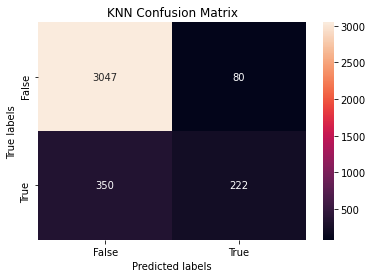

In [11]:
y_true_base, y_pred_base, y_pred_prob_base = findBestModel(imbalancedstats)
savePredictionsToFile("../predictions/svm_predictions.csv", y_true_base, y_pred_base, y_pred_prob_base)
saveBestConfusionMatrix('../confusionMatrices/SVM_confusionMatrix.png', y_true_base, y_pred_base)

# Oversampling

In [ ]:
oversamplingstats = svm_training(preprocessed_df, "over")

__________________________________________________________________________________Iteration:0
Random over-sampling:1    7295
0    7295
Name: Revenue, dtype: int64


In [ ]:
printStats(oversamplingstats)

In [ ]:
y_true_over, y_pred_over, y_pred_prob_over = findBestModel(oversamplingstats)
savePredictionsToFile("../predictions/svm_over_predictions.csv", y_true_over, y_pred_over, y_pred_prob_over)
saveBestConfusionMatrix('../confusionMatrices/SVM_over_confusionMatrix.png', y_true_over, y_pred_over)

# Undersampling

In [ ]:
undersamplingstats = svm_training(preprocessed_df, "under")

In [ ]:
printStats(undersamplingstats)

In [ ]:
y_true_under, y_pred_under, y_pred_prob_under = findBestModel(undersamplingstats)
savePredictionsToFile("../predictions/svm_under_predictions.csv", y_true_under, y_pred_under, y_pred_prob_under)
saveBestConfusionMatrix('../confusionMatrices/SVM_under_confusionMatrix.png', y_true_under, y_pred_under)